In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.mul import UnaryMul_int
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np
global perfect_result_RMSE
global perfect_result_MAE
import copy
import pandas as pd
from pandas import Series, DataFrame
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
rng = "Sobol"

In [4]:
def base_line(bw):    
    col = 10000
    modes = ["unipolar"]
    static = True
    bitwidth = bw
    stype = torch.int8
    rtype = torch.long
    global perfect_result_RMSE
    global perfect_result_MAE
    
    for mode in modes:
#         if mode is "unipolar":
#             input_prob = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
#             iVec = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
#         elif mode is "bipolar":
#             input_prob = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
#             iVec = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

        low_bound = 0
        up_bound = 2**bitwidth
        if mode is "unipolar":
            up_bound = 2**bitwidth
        elif mode is "bipolar":
            low_bound = 0
            up_bound = 2**(bitwidth-1)

        input_prob_list = []
        iVec_list = []
        for input_val in range(low_bound, up_bound+1, 1):
            input_prob_list.append(input_val)
            iVec_list.append(input_val)

        input_prob = torch.tensor(input_prob_list).type(torch.float).div(up_bound).to(device)
        iVec = torch.tensor(iVec_list).type(torch.float).div(up_bound).to(device)

        dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype, back=False,back_up=None).to(device)

        oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)

        iVecPE = ProgressiveError(iVec, mode=mode).to(device)
        oVecPE = ProgressiveError(oVec, mode=mode).to(device)

        iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
        iVecRNG = RNG(bitwidth, 1, rng)().to(device)
        iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                iBS = iVecBS(torch.tensor([i]))
                iVecPE.Monitor(iBS)
                oVecU = dut_mul(iBS)   
                oVecPE.Monitor(oVecU)
            print("mode:",str(mode))
            print("--- %s base seconds ---" % (time.time() - start_time))
    #         print("input error: ", torch.min(iVecPE()[1]), torch.max(iVecPE()[1]))
    #         print("output error: ", torch.min(oVecPE()[1]), torch.max(oVecPE()[1]))
            result_pe = oVecPE()[1].cpu().numpy()
            print("base RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
            perfect_result_RMSE = math.sqrt(sum(result_pe**2)/len(result_pe))
            print("base MAE: {:1.4}".format(np.mean(np.abs(result_pe))))
            perfect_result_MAE = np.mean(np.abs(result_pe))
#             print("bias", sum(result_pe)/len(result_pe))
#             fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
#             plt.title("Histogram for final output error")
#             plt.show()

In [5]:
base_line(4)

mode: unipolar
--- 0.015626192092895508 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574


In [6]:
import matplotlib.pyplot as plt
def mul_int_save_counter(bw):
    base_line(bw)
    global perfect_result_RMSE
    global perfect_result_MAE
    col = 10000
    modes = ["unipolar"]
    static = True
    bitwidth = bw
    stype = torch.int8
    rtype = torch.long
    
    time_list=[]
    rmse_list=[]
    mae_list=[]
    mae_per_list=[]
    rmse_per_list=[]
    for power_off in range(0,2**bitwidth):
        for mode in modes:
            low_bound = 0
            up_bound = 2**bitwidth
            if mode is "unipolar":
                up_bound = 2**bitwidth
            elif mode is "bipolar":
                low_bound = 0
                up_bound = 2**(bitwidth-1)

            input_prob_list = []
            iVec_list = []
            for input_val in range(low_bound, up_bound+1, 1):
                input_prob_list.append(input_val)
                iVec_list.append(input_val)

            input_prob = torch.tensor(input_prob_list).type(torch.float).div(up_bound).to(device)
            iVec = torch.tensor(iVec_list).type(torch.float).div(up_bound).to(device)

            dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype,  back=False,back_up=None).to(device)

            oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            oVecPE = ProgressiveError(oVec, mode=mode).to(device)

            iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

            error_print = []
            idx_print = []
            
            with torch.no_grad():
                start_time = time.time()
                for i in range(0,power_off):
                    iBS_0 = iVecBS(torch.tensor([i]))
                    iVecPE.Monitor(iBS_0)
                    oVecU_0 = dut_mul(iBS_0)   
                    oVecPE.Monitor(oVecU_0)
                    result_pe = oVecPE()[1].cpu().numpy()
                    error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
    #                 idx_print.append(dut_mul.rng_idx)
    #                 print(dut_mul.rng_idx.mul(0))
                save = copy.deepcopy(dut_mul.rng_idx)
                dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype, back=True, back_up=save).to(device)
                for i in range(power_off,2**bitwidth):
                    iBS_1 = iVecBS(torch.tensor([i]))
                    iVecPE.Monitor(iBS_1)
                    oVecU_1 = dut_mul(iBS_1)   
                    oVecPE.Monitor(oVecU_1)
                    result_pe = oVecPE()[1].cpu().numpy()
                    error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                    idx_print.append(dut_mul.rng_idx)

                ax = Series(error_print).plot.line(legend=False,label=power_off)
                ax.set_ylim(0)
                ax.set_title(f"save cnter, bitwidth: {bw}")
                result_pe = oVecPE()[1].cpu().numpy()
                time_list.append(time.time() - start_time)
                rmse_list.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                mae_list.append(np.mean(np.abs(result_pe)))
                print(np.mean(np.abs(result_pe)))
                mae_per_list.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE)/perfect_result_MAE)
                rmse_per_list.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE)/perfect_result_RMSE)
                
    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list)/len(time_list)))         
    print("Avg RMSE", sum(rmse_list)/len(rmse_list))
    print("Avg MAE: {:1.4}".format(sum(mae_list)/len(mae_list)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list)/len(rmse_per_list)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list)/len(mae_per_list)))
    #                 print("Mode:",str(mode))
#                 print("--- %s seconds ---" % (time.time() - start_time))
        #         print("input error: ", torch.min(iVecPE()[1]), torch.max(iVecPE()[1]))
        #         print("output error: ", torch.min(oVecPE()[1]), torch.max(oVecPE()[1]))
#                 print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
#                 print("MAE: {:1.4}".format(np.mean(np.abs(result_pe))))
        #         print("bias", sum(result_pe)/len(result_pe))
#                 print("RMSE_error from perfect:",(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE))
#                 print("MAE_error from perfect:",(np.mean(np.abs(result_pe))-perfect_result_MAE))

In [7]:
import matplotlib.pyplot as plt
def mul_int_not_save_counter(bw):
    base_line(bw)
    global perfect_result_RMSE
    global perfect_result_MAE
    col = 10000
    modes = ["unipolar"]
    static = True
    bitwidth = bw
    stype = torch.int8
    rtype = torch.long
    time_list_0=[]
    rmse_list_0=[]
    mae_list_0=[]
    mae_per_list_0=[]
    rmse_per_list_0=[]

    for power_off in range(0,2**bitwidth):
        for mode in modes:
            low_bound = 0
            up_bound = 2**bitwidth
            if mode is "unipolar":
                up_bound = 2**bitwidth
            elif mode is "bipolar":
                low_bound = 0
                up_bound = 2**(bitwidth-1)

            input_prob_list = []
            iVec_list = []
            for input_val in range(low_bound, up_bound+1, 1):
                input_prob_list.append(input_val)
                iVec_list.append(input_val)

            input_prob = torch.tensor(input_prob_list).type(torch.float).div(up_bound).to(device)
            iVec = torch.tensor(iVec_list).type(torch.float).div(up_bound).to(device)

            dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype,back=False,back_up=0).to(device)

            oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            oVecPE = ProgressiveError(oVec, mode=mode).to(device)

            iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

            error_print = []
            idx_print = []
            

            with torch.no_grad():
                start_time = time.time()
                for i in range(0,power_off):
                    iBS_0 = iVecBS(torch.tensor([i]))
                    iVecPE.Monitor(iBS_0)
                    oVecU_0 = dut_mul(iBS_0)   
                    oVecPE.Monitor(oVecU_0)
                    result_pe = oVecPE()[1].cpu().numpy()
                    error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                    idx_print.append(dut_mul.rng_idx)
                dut_mul =UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype, back=False, back_up=None).to(device)
                for i in range(power_off,2**bitwidth):
                    iBS_1 = iVecBS(torch.tensor([i]))
                    iVecPE.Monitor(iBS_1)
                    oVecU_1 = dut_mul(iBS_1)   
                    oVecPE.Monitor(oVecU_1)
                    result_pe = oVecPE()[1].cpu().numpy()
                    error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                    idx_print.append(dut_mul.rng_idx)
                ax = Series(error_print).plot.line(legend=False,label=power_off)
                ax.set_ylim(0)
                ax.set_title(f"not cnter, bitwidth: {bw}")
                result_pe = oVecPE()[1].cpu().numpy()
                time_list_0.append(time.time() - start_time)
                rmse_list_0.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                print(np.mean(np.abs(result_pe)))
                mae_list_0.append(np.mean(np.abs(result_pe)))
                mae_per_list_0.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE)/perfect_result_MAE)
                rmse_per_list_0.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE)/perfect_result_RMSE)
                
    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list_0)/len(time_list_0)))         
    print("Avg RMSE", sum(rmse_list_0)/len(rmse_list_0))
    print("Avg MAE: {:1.4}".format(sum(mae_list_0)/len(mae_list_0)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list_0)/len(rmse_per_list_0)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list_0)/len(mae_per_list_0)))
#                 print("Mode:",str(mode))
#                 print("--- %s seconds ---" % (time.time() - start_time))
#         #         print("input error: ", torch.min(iVecPE()[1]), torch.max(iVecPE()[1]))
#         #         print("output error: ", torch.min(oVecPE()[1]), torch.max(oVecPE()[1]))
#                 result_pe = oVecPE()[1].cpu().numpy()
#                 print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
#                 print("MAE: {:1.4}".format(np.mean(np.abs(result_pe))))
#         #         print("bias", sum(result_pe)/len(result_pe))
#                 print("RMSE_error from perfect:",(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE))
#                 print("MAE_error from perfect:",(np.mean(np.abs(result_pe))-perfect_result_MAE))
#                 ax = Series(error_print).plot.line(legend=True,label=power_off)
#                 ax.set_ylim(0)
#                 ax.set_title(f"not save cnter, bitwidth: {bw}")

mode: unipolar
--- 0.01562643051147461 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
0.025735294
0.022058824
0.018382354
0.036764707
0.018382354
0.022058824
0.029411765
0.029411765
0.029411765
0.029411765
0.029411765
0.029411765
0.018382354
0.018382354
0.022058824
0.029411765
Mode: unipolar
--- 0.020568668842315674 Average seconds ---
Avg RMSE 0.040644907895054476
Avg MAE: 0.02551
Avg RMSE_error from perfect: 11.87%
Avg MAE_error from perfect: 18.75%


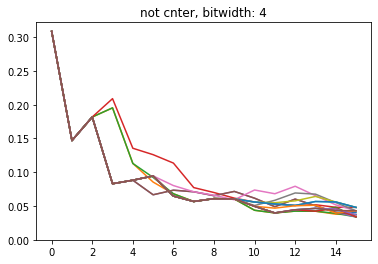

In [41]:
mul_int_not_save_counter(4)

mode: unipolar
--- 0.01562666893005371 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
0.025735294
0.025735294
0.025735294
0.033088237
0.025735294
0.018382354
0.040441178
0.025735294
0.025735294
0.025735294
0.036764707
0.033088237
0.029411765
0.018382354
0.025735294
0.029411765
Mode: unipolar
--- 0.01814080774784088 Average seconds ---
Avg RMSE 0.041998702067517296
Avg MAE: 0.0278
Avg RMSE_error from perfect: 8.59%
Avg MAE_error from perfect: 15.18%


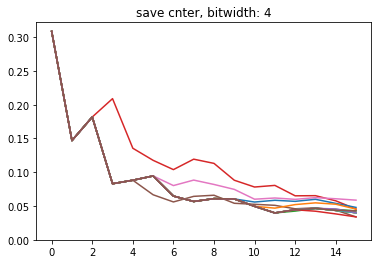

In [42]:
mul_int_save_counter(4)

mode: unipolar
--- 0.015625715255737305 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
Mode: unipolar
--- 0.02019059658050537 Average seconds ---
Avg RMSE 0.041998702067517296
Avg MAE: 0.0278
Avg RMSE_error from perfect: 8.59%
Avg MAE_error from perfect: 15.18%


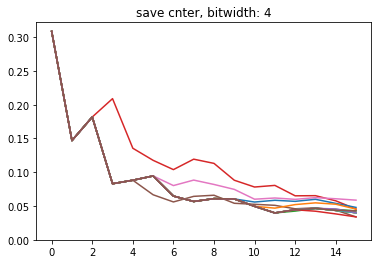

In [38]:
mul_int_save_counter(4)

mode: unipolar
--- 0.01901698112487793 base seconds ---
base RMSE 0.018042195912175804
base MAE: 0.01042
Mode: unipolar
--- 0.03926064074039459 Average seconds ---
Avg RMSE 0.02418762937600279
Avg MAE: 0.01471
Avg RMSE_error from perfect: 34.95%
Avg MAE_error from perfect: 43.47%


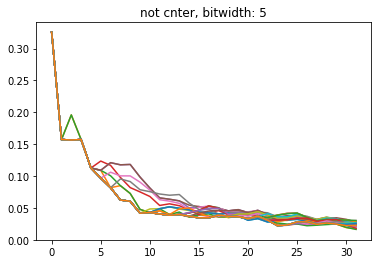

In [131]:
mul_int_not_save_counter(5)

mode: unipolar
--- 0.019017457962036133 base seconds ---
base RMSE 0.018042195912175804
base MAE: 0.01042
Mode: unipolar
--- 0.02999582141637802 Average seconds ---
Avg RMSE 0.020009940122869472
Avg MAE: 0.0121
Avg RMSE_error from perfect: 11.50%
Avg MAE_error from perfect: 17.33%


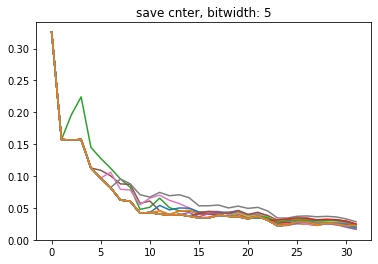

In [132]:
mul_int_save_counter(5)

mode: unipolar
--- 0.06706094741821289 base seconds ---
base RMSE 0.01146561540164598
base MAE: 0.007452
Mode: unipolar
--- 0.07659365236759186 Average seconds ---
Avg RMSE 0.013376081497997279
Avg MAE: 0.009236
Avg RMSE_error from perfect: 17.82%
Avg MAE_error from perfect: 26.56%


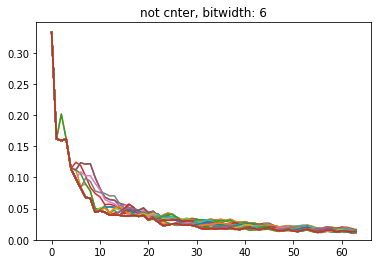

In [135]:
mul_int_not_save_counter(6)

mode: unipolar
--- 0.04904437065124512 base seconds ---
base RMSE 0.01146561540164598
base MAE: 0.007452
Mode: unipolar
--- 0.0681396946310997 Average seconds ---
Avg RMSE 0.012273425459197353
Avg MAE: 0.008207
Avg RMSE_error from perfect: 7.92%
Avg MAE_error from perfect: 11.64%


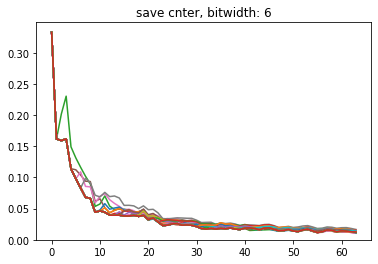

In [136]:
mul_int_save_counter(6)

mode: unipolar
--- 0.146132230758667 base seconds ---
base RMSE 0.0030531159581229693
base MAE: 0.002113
Mode: unipolar
--- 0.2994007486850023 Average seconds ---
Avg RMSE 0.003317205903863465
Avg MAE: 0.002337
Avg RMSE_error from perfect: 8.84%
Avg MAE_error from perfect: 11.04%


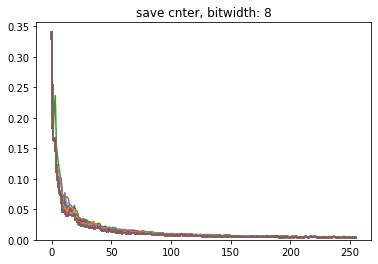

In [137]:
mul_int_save_counter(8)

mode: unipolar
--- 0.21919941902160645 base seconds ---
base RMSE 0.0030531159581229693
base MAE: 0.002113
Mode: unipolar
--- 0.3126122308894992 Average seconds ---
Avg RMSE 0.0038638021139345232
Avg MAE: 0.002791
Avg RMSE_error from perfect: 26.61%
Avg MAE_error from perfect: 32.25%


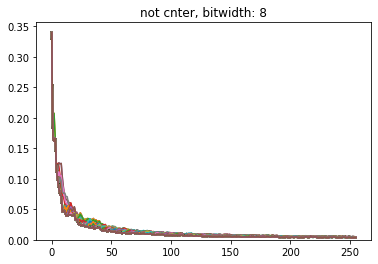

In [138]:
mul_int_not_save_counter(8)

In [6]:
import matplotlib.pyplot as plt
def mul_int_save_counter_multi(bw, n):
    base_line(bw)
    global perfect_result_RMSE
    global perfect_result_MAE
    col = 10000
    modes = ["unipolar"]
    static = True
    bitwidth = bw
    stype = torch.int8
    rtype = torch.long
    
    time_list=[]
    rmse_list=[]
    mae_list=[]
    mae_per_list=[]
    rmse_per_list=[]
    
    off_cycle = []
    for i in range(0+math.floor(2**bw/n),2**bw, math.floor(2**bw/n)):
        off_cycle.append(i)
    
    for mode in modes:
        low_bound = 0
        up_bound = 2**bitwidth
        if mode is "unipolar":
            up_bound = 2**bitwidth
        elif mode is "bipolar":
            low_bound = 0
            up_bound = 2**(bitwidth-1)

        input_prob_list = []
        iVec_list = []
        for input_val in range(low_bound, up_bound+1, 1):
            input_prob_list.append(input_val)
            iVec_list.append(input_val)

        input_prob = torch.tensor(input_prob_list).type(torch.float).div(up_bound).to(device)
        iVec = torch.tensor(iVec_list).type(torch.float).div(up_bound).to(device)

        dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype,  back=False,back_up=None).to(device)

        oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)

        iVecPE = ProgressiveError(iVec, mode=mode).to(device)
        oVecPE = ProgressiveError(oVec, mode=mode).to(device)

        iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
        iVecRNG = RNG(bitwidth, 1, rng)().to(device)
        iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

        error_print = []
        idx_print = []

        with torch.no_grad():
            start_time = time.time()
            for i in range(0,2**bitwidth):
                if i in off_cycle:
                    save = copy.deepcopy(dut_mul.rng_idx)
                    dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype, back=True, back_up=save).to(device)
                iBS_0 = iVecBS(torch.tensor([i]))
                iVecPE.Monitor(iBS_0)
                oVecU_0 = dut_mul(iBS_0)   
                oVecPE.Monitor(oVecU_0)
                result_pe = oVecPE()[1].cpu().numpy()
                error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))


            ax = Series(error_print).plot.line(legend=False)
            ax.set_ylim(0)
            ax.set_title(f"save cnter, bitwidth: {bw}")
            result_pe = oVecPE()[1].cpu().numpy()
            time_list.append(time.time() - start_time)
            rmse_list.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
            mae_list.append(np.mean(np.abs(result_pe)))
            mae_per_list.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE)/perfect_result_MAE)
            rmse_per_list.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE)/perfect_result_RMSE)
                
    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list)/len(time_list)))         
    print("Avg RMSE", sum(rmse_list)/len(rmse_list))
    print("Avg MAE: {:1.4}".format(sum(mae_list)/len(mae_list)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list)/len(rmse_per_list)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list)/len(mae_per_list)))

In [7]:
import matplotlib.pyplot as plt
def mul_int_not_save_counter_multi(bw,n):
    base_line(bw)
    global perfect_result_RMSE
    global perfect_result_MAE
    col = 10000
    modes = ["unipolar"]
    static = True
    bitwidth = bw
    stype = torch.int8
    rtype = torch.long
    time_list_0=[]
    rmse_list_0=[]
    mae_list_0=[]
    mae_per_list_0=[]
    rmse_per_list_0=[]

    off_cycle = []
    for i in range(0+math.floor(2**bw/n),2**bw, math.floor(2**bw/n)):
        off_cycle.append(i)

    for mode in modes:
        low_bound = 0
        up_bound = 2**bitwidth
        if mode is "unipolar":
            up_bound = 2**bitwidth
        elif mode is "bipolar":
            low_bound = 0
            up_bound = 2**(bitwidth-1)

        input_prob_list = []
        iVec_list = []
        for input_val in range(low_bound, up_bound+1, 1):
            input_prob_list.append(input_val)
            iVec_list.append(input_val)

        input_prob = torch.tensor(input_prob_list).type(torch.float).div(up_bound).to(device)
        iVec = torch.tensor(iVec_list).type(torch.float).div(up_bound).to(device)

        dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype,back=False,back_up=0).to(device)

        oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)

        iVecPE = ProgressiveError(iVec, mode=mode).to(device)
        oVecPE = ProgressiveError(oVec, mode=mode).to(device)

        iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
        iVecRNG = RNG(bitwidth, 1, rng)().to(device)
        iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)

        error_print = []
        idx_print = []


        with torch.no_grad():
            start_time = time.time()
            for i in range(0,2**bitwidth):
                if i in off_cycle:
                    dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype, back=False, back_up=None).to(device)
                iBS_0 = iVecBS(torch.tensor([i]))
                iVecPE.Monitor(iBS_0)
                oVecU_0 = dut_mul(iBS_0)   
                oVecPE.Monitor(oVecU_0)
                result_pe = oVecPE()[1].cpu().numpy()
                error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                idx_print.append(dut_mul.rng_idx)
                
#                 for i in range(power_off,2**bitwidth):
#                     iBS_1 = iVecBS(torch.tensor([i]))
#                     iVecPE.Monitor(iBS_1)
#                     oVecU_1 = dut_mul(iBS_1)   
#                     oVecPE.Monitor(oVecU_1)
#                     result_pe = oVecPE()[1].cpu().numpy()
#                     error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
#                     idx_print.append(dut_mul.rng_idx)
            ax = Series(error_print).plot.line(legend=False)
            ax.set_ylim(0)
            ax.set_title(f"not cnter, bitwidth: {bw}")
            result_pe = oVecPE()[1].cpu().numpy()
            time_list_0.append(time.time() - start_time)
            rmse_list_0.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
            mae_list_0.append(np.mean(np.abs(result_pe)))
            mae_per_list_0.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE)/perfect_result_MAE)
            rmse_per_list_0.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE)/perfect_result_RMSE)
                
    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list_0)/len(time_list_0)))         
    print("Avg RMSE", sum(rmse_list_0)/len(rmse_list_0))
    print("Avg MAE: {:1.4}".format(sum(mae_list_0)/len(mae_list_0)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list_0)/len(rmse_per_list_0)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list_0)/len(mae_per_list_0)))


mode: unipolar
--- 0.0 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
Mode: unipolar
--- 0.03124260902404785 Average seconds ---
Avg RMSE 0.0625
Avg MAE: 0.04779
Avg RMSE_error from perfect: 55.84%
Avg MAE_error from perfect: 85.71%


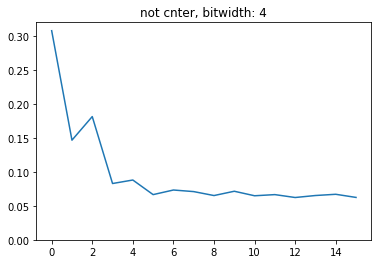

In [8]:
mul_int_not_save_counter_multi(4,3)

mode: unipolar
--- 0.010009527206420898 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
Mode: unipolar
--- 0.032030582427978516 Average seconds ---
Avg RMSE 0.0625
Avg MAE: 0.04779
Avg RMSE_error from perfect: 55.84%
Avg MAE_error from perfect: 85.71%


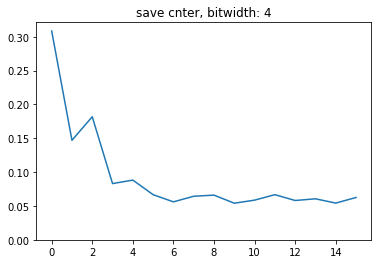

In [9]:
mul_int_save_counter_multi(4,3)

mode: unipolar
--- 0.015641450881958008 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
0
2
4
6
8
10
12
14
Mode: unipolar
--- 0.03133440017700195 Average seconds ---
Avg RMSE 0.11839148667723984
Avg MAE: 0.07721
Avg RMSE_error from perfect: 195.20%
Avg MAE_error from perfect: 200.00%


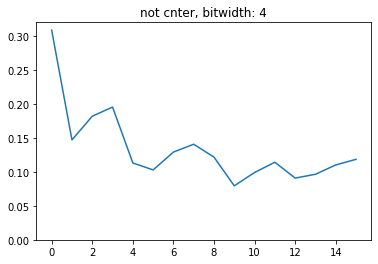

In [14]:
mul_int_not_save_counter_multi(4,7)

mode: unipolar
--- 0.018016338348388672 base seconds ---
base RMSE 0.018042195912175804
base MAE: 0.01042
Mode: unipolar
--- 0.04303884506225586 Average seconds ---
Avg RMSE 0.10030729300655576
Avg MAE: 0.07197
Avg RMSE_error from perfect: 455.96%
Avg MAE_error from perfect: 590.91%


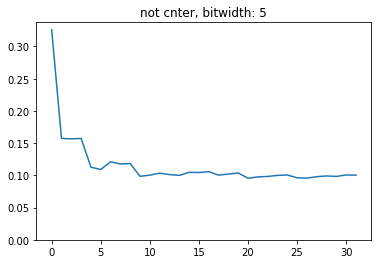

In [37]:
mul_int_not_save_counter_multi(5,3)

mode: unipolar
--- 0.019016265869140625 base seconds ---
base RMSE 0.018042195912175804
base MAE: 0.01042
Mode: unipolar
--- 0.04003334045410156 Average seconds ---
Avg RMSE 0.040343576522993925
Avg MAE: 0.02746
Avg RMSE_error from perfect: 123.61%
Avg MAE_error from perfect: 163.64%


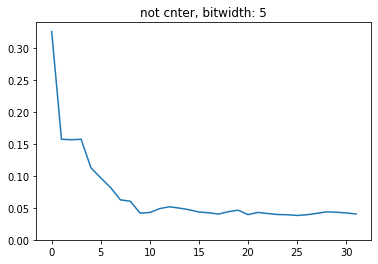

In [38]:
mul_int_not_save_counter_multi(5,7)

mode: unipolar
--- 0.009008407592773438 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
Mode: unipolar
--- 0.029863834381103516 Average seconds ---
Avg RMSE 0.04010555924498424
Avg MAE: 0.02574
Avg RMSE_error from perfect: 0.00%
Avg MAE_error from perfect: 0.00%


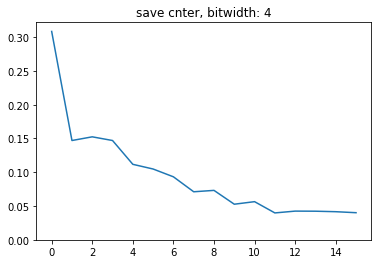

In [39]:
mul_int_save_counter_multi(4,3)

mode: unipolar
--- 0.01000833511352539 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
Mode: unipolar
--- 0.029026269912719727 Average seconds ---
Avg RMSE 0.04010555924498424
Avg MAE: 0.02574
Avg RMSE_error from perfect: 0.00%
Avg MAE_error from perfect: 0.00%


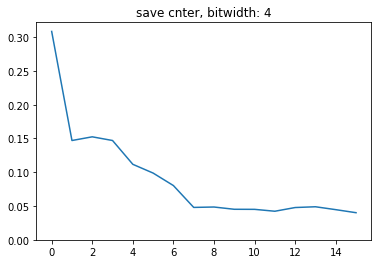

In [40]:
mul_int_save_counter_multi(4,7)

mode: unipolar
--- 0.018016815185546875 base seconds ---
base RMSE 0.018042195912175804
base MAE: 0.01042
4
8
12
16
20
24
28
Mode: unipolar
--- 0.04531383514404297 Average seconds ---
Avg RMSE 0.0249288761005458
Avg MAE: 0.0161
Avg RMSE_error from perfect: 38.17%
Avg MAE_error from perfect: 54.55%


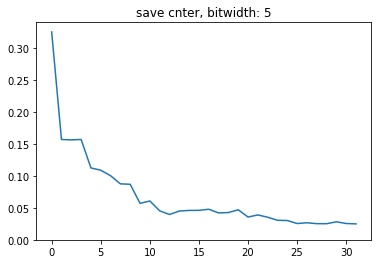

In [58]:
mul_int_save_counter_multi(5,3)

mode: unipolar
--- 0.26123809814453125 base seconds ---
base RMSE 0.0030531159581229693
base MAE: 0.002113
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
Mode: unipolar
--- 0.41437578201293945 Average seconds ---
Avg RMSE 0.0038757319543732387
Avg MAE: 0.002751
Avg RMSE_error from perfect: 26.94%
Avg MAE_error from perfect: 30.22%


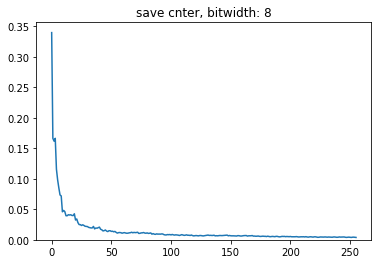

In [67]:
mul_int_save_counter_multi(8,7)

mode: unipolar
--- 0.2602348327636719 base seconds ---
base RMSE 0.0030531159581229693
base MAE: 0.002113
9
18
27
36
45
54
63
72
81
90
99
108
117
126
135
144
153
162
171
180
189
198
207
216
225
234
243
252
Mode: unipolar
--- 0.35332560539245605 Average seconds ---
Avg RMSE 0.01692552434704527
Avg MAE: 0.01336
Avg RMSE_error from perfect: 454.37%
Avg MAE_error from perfect: 532.37%


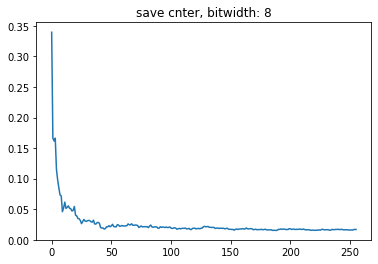

In [69]:
mul_int_save_counter_multi(8,8)

In [31]:
import matplotlib.pyplot as plt
def mul_int_not_save_counter_multi(bw):
    base_line(bw)
    global perfect_result_RMSE
    global perfect_result_MAE
    col = 10000
    modes = ["unipolar"]
    static = True
    bitwidth = bw
    stype = torch.int8
    rtype = torch.long
    time_list_0=[]
    rmse_list_0=[]
    mae_list_0=[]
    mae_per_list_0=[]
    rmse_per_list_0=[]
    error_print=[]

    for n in range(1,2**bw):
        
        off_cycle = []
#         print(math.floor(bw/n))
        for i in range(0+math.floor(2**bw/n),2**bw, math.floor(2**bw/n)):
            off_cycle.append(i)

        for mode in modes:
            low_bound = 0
            up_bound = 2**bitwidth
            if mode is "unipolar":
                up_bound = 2**bitwidth
            elif mode is "bipolar":
                low_bound = 0
                up_bound = 2**(bitwidth-1)

            input_prob_list = []
            iVec_list = []
            for input_val in range(low_bound, up_bound+1, 1):
                input_prob_list.append(input_val)
                iVec_list.append(input_val)

            input_prob = torch.tensor(input_prob_list).type(torch.float).div(up_bound).to(device)
            iVec = torch.tensor(iVec_list).type(torch.float).div(up_bound).to(device)

            dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype,back=False,back_up=0).to(device)

            oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            oVecPE = ProgressiveError(oVec, mode=mode).to(device)

            iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)


            with torch.no_grad():
                start_time = time.time()
                for i in range(0,2**bitwidth):
                    if i in off_cycle:
#                         print(i)
                        dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype, back=False, back_up=None).to(device)
                    iBS_0 = iVecBS(torch.tensor([i]))
                    iVecPE.Monitor(iBS_0)
                    oVecU_0 = dut_mul(iBS_0)   
                    oVecPE.Monitor(oVecU_0)
                    result_pe = oVecPE()[1].cpu().numpy()
                    
#                     idx_print.append(dut_mul.rng_idx)
                
                
                result_pe = oVecPE()[1].cpu().numpy()
                error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                time_list_0.append(time.time() - start_time)
                rmse_list_0.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                mae_list_0.append(np.mean(np.abs(result_pe)))
                mae_per_list_0.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE)/perfect_result_MAE)
                rmse_per_list_0.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE)/perfect_result_RMSE)
#     print(error_print)
    ax = Series(error_print).plot.line(legend=False)
    ax.set_ylim(0)
    ax.set_title(f"not cnter,multi, bitwidth: {bw}")
    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list_0)/len(time_list_0)))         
    print("Avg RMSE", sum(rmse_list_0)/len(rmse_list_0))
    print("Avg MAE: {:1.4}".format(sum(mae_list_0)/len(mae_list_0)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list_0)/len(rmse_per_list_0)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list_0)/len(mae_per_list_0)))


mode: unipolar
--- 0.012001991271972656 base seconds ---
base RMSE 0.04010555924498424
base MAE: 0.02574
Mode: unipolar
--- 0.02035180727640788 Average seconds ---
Avg RMSE 0.11479623516308496
Avg MAE: 0.08603
Avg RMSE_error from perfect: 186.24%
Avg MAE_error from perfect: 234.29%


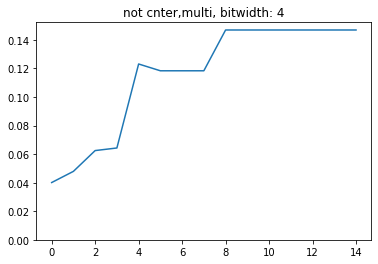

In [32]:
mul_int_not_save_counter_multi(4)

mode: unipolar
--- 0.0312502384185791 base seconds ---
base RMSE 0.018042195912175804
base MAE: 0.01042
Mode: unipolar
--- 0.042632364457653414 Average seconds ---
Avg RMSE 0.11757380979821068
Avg MAE: 0.08966
Avg RMSE_error from perfect: 551.66%
Avg MAE_error from perfect: 760.70%


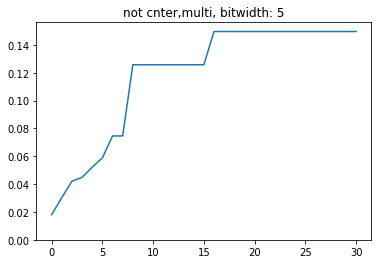

In [33]:
mul_int_not_save_counter_multi(5)

mode: unipolar
--- 0.06250357627868652 base seconds ---
base RMSE 0.010255158176779588
base MAE: 0.006731
Mode: unipolar
--- 0.06982200486319405 Average seconds ---
Avg RMSE 0.11749966812876719
Avg MAE: 0.09193
Avg RMSE_error from perfect: 1045.76%
Avg MAE_error from perfect: 1265.87%


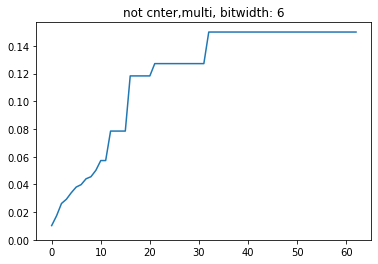

In [34]:
mul_int_not_save_counter_multi(6)

In [35]:
import matplotlib.pyplot as plt
def mul_int_save_counter_multi(bw):
    base_line(bw)
    global perfect_result_RMSE
    global perfect_result_MAE
    col = 10000
    modes = ["unipolar"]
    static = True
    bitwidth = bw
    stype = torch.int8
    rtype = torch.long
    
    time_list=[]
    rmse_list=[]
    mae_list=[]
    mae_per_list=[]
    rmse_per_list=[]
    error_print=[]
    
    for n in range(1,2**bw):
        off_cycle = []
        for i in range(0+math.floor(2**bw/n),2**bw, math.floor(2**bw/n)):
            off_cycle.append(i)

        for mode in modes:
            low_bound = 0
            up_bound = 2**bitwidth
            if mode is "unipolar":
                up_bound = 2**bitwidth
            elif mode is "bipolar":
                low_bound = 0
                up_bound = 2**(bitwidth-1)

            input_prob_list = []
            iVec_list = []
            for input_val in range(low_bound, up_bound+1, 1):
                input_prob_list.append(input_val)
                iVec_list.append(input_val)

            input_prob = torch.tensor(input_prob_list).type(torch.float).div(up_bound).to(device)
            iVec = torch.tensor(iVec_list).type(torch.float).div(up_bound).to(device)

            dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype,  back=False,back_up=None).to(device)

            oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            oVecPE = ProgressiveError(oVec, mode=mode).to(device)

            iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype).to(device)


            with torch.no_grad():
                start_time = time.time()
                for i in range(0,2**bitwidth):
                    if i in off_cycle:
                        save = copy.deepcopy(dut_mul.rng_idx)
                        dut_mul = UnaryMul_int(bitwidth=bitwidth, mode=mode, static=static, input_prob_1=input_prob, stype=stype, rtype=rtype, back=True, back_up=save).to(device)
                    iBS_0 = iVecBS(torch.tensor([i]))
                    iVecPE.Monitor(iBS_0)
                    oVecU_0 = dut_mul(iBS_0)   
                    oVecPE.Monitor(oVecU_0)
                    result_pe = oVecPE()[1].cpu().numpy()
                    
                result_pe = oVecPE()[1].cpu().numpy()
                error_print.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                time_list.append(time.time() - start_time)
                rmse_list.append(math.sqrt(sum(result_pe**2)/len(result_pe)))
                mae_list.append(np.mean(np.abs(result_pe)))
                mae_per_list.append(abs(np.mean(np.abs(result_pe))-perfect_result_MAE)/perfect_result_MAE)
                rmse_per_list.append(abs(math.sqrt(sum(result_pe**2)/len(result_pe))-perfect_result_RMSE)/perfect_result_RMSE)
    
    ax = Series(error_print).plot.line(legend=False)
    ax.set_ylim(0)
    ax.set_title(f"save cnter, bitwidth: {bw}")         
    print("Mode:",str(mode))
    print("--- %s Average seconds ---" % (sum(time_list)/len(time_list)))         
    print("Avg RMSE", sum(rmse_list)/len(rmse_list))
    print("Avg MAE: {:1.4}".format(sum(mae_list)/len(mae_list)))
    print("Avg RMSE_error from perfect: {:.2%}".format(sum(rmse_per_list)/len(rmse_per_list)))
    print("Avg MAE_error from perfect: {:.2%}".format(sum(mae_per_list)/len(mae_per_list)))


mode: unipolar
--- 0.01801586151123047 base seconds ---
base RMSE 0.018042195912175804
base MAE: 0.01042
Mode: unipolar
--- 0.03477339590749433 Average seconds ---
Avg RMSE 0.09813752696016588
Avg MAE: 0.07719
Avg RMSE_error from perfect: 443.93%
Avg MAE_error from perfect: 641.06%


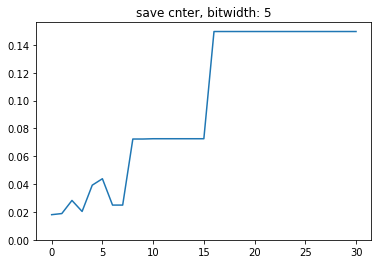

In [37]:
mul_int_save_counter_multi(5)